<a href="https://colab.research.google.com/github/Romario1975/graphic_arts/blob/main/NPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.0 Загружаем Дата cет с примерами по правильным формулировкам НПА и формулировкам содержащим корупциогенные признаки. Устанавливаем необхожимые для работы библиотеки

Загружаем библиотеку Transformers она представляет инструменты и модели из Huggging Face для их использования

In [ ]:
! pip install transformers

In [ ]:
# импорртируем пандас - библиотека для работы с таблицами
import pandas as pd

In [ ]:
from transformers import BertTokenizer

In [ ]:
import torch

1.1 Импортируем данные

In [ ]:
df_label_studio = pd.read_csv('/content/data_set.csv',  sep='\t')

In [ ]:
df_label_studio

,"annotation_id,""annotator"",""bad"",""created_at"",""id"",""lead_time"",""sentiment"",""updated_at"";"
0,"13519,""36"",""«В случае утраты действующей лицен..."
1,"13520,""36"",""«При необходимости, заявителю необ..."
2,"13521,""38"",""""""После регистрации принятых от гр..."
3,"13522,""38"",""""""В случаях, требующих проведения ..."
4,"13523,""38"",""""""Акт о выборе земельного участка ..."
...,...
136,наличие в представленных документах недостовер...
137,"документы имеют серьезные повреждения, наличие..."
138,"13607,""34"",""«.... В результате рассмотрения хо..."
139,поддержать ходатайство и обратиться в Правител...


In [ ]:
# импортируем данные
df = pd.read_excel('/content/data_set_new.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  88 non-null     object
 1   label     88 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


In [ ]:
df.head(20)

,sentence,label
0,После регистрации принятых от гражданина докум...,1
1,"В случаях, требующих проведения специальной пр...",0
2,Распоряжение об утверждении проекта границ зем...,0
3,Уполномоченный орган местной администрации (да...,0
4,Гражданину может быть отказано в постановке на...,0
5,В случае утраты действующей лицензии на право ...,1
6,"При необходимости, заявителю необходимо предос...",1
7,После регистрации принятых от гражданина докум...,1
8,"В случаях, требующих проведения специальной пр...",1
9,Акт о выборе земельного участка оформляется в ...,1


In [ ]:
df['sentence'].loc[:2]

0    После регистрации принятых от гражданина докум...
1    В случаях, требующих проведения специальной пр...
2    Распоряжение об утверждении проекта границ зем...
Name: sentence, dtype: object

In [ ]:
df.columns

Index(['sentence', 'label '], dtype='object')

In [ ]:
df = df.rename(columns ={ 'label ':'label'})

1.2 Делаем выборочный обзор полученных данных, проверояем данные на наличие пропусков

In [ ]:
df['label'].value_counts()

1    51
0    37
Name: label, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  88 non-null     object
 1   label     88 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


In [ ]:
df.iloc[0,0]

'После регистрации принятых от гражданина документов они в течение одного рабочего дня направляются в юридическую службу для проведения правовой экспертизы. В случае положительного результата правовой экспертизы документов юридическая служба готовит проект распоряжения о даче согласия на вступление в брак несовершеннолетних лиц'

In [ ]:
df['label'][0]

1

Положительные примеры

In [ ]:
df.loc[df['label'] ==0.0].sample(5)

,sentence,label
72,Если день обращения (при поступлении заявления...,0
67,Уполномоченный орган местной администрации (да...,0
77,устанавливают необходимость согласования созда...,0
84,Минтерразвития Забайкальского края переносит д...,0
2,Распоряжение об утверждении проекта границ зем...,0


Отрицательные примеры с корупциогенными признаками

In [ ]:
df.loc[df['label'] ==1.0].sample(5)

,sentence,label
17,Маршрут может быть закрыт или приостановлен в ...,1
31,В случае утраты действующей лицензии на право ...,1
28,Орган местной администрации в области земель...,1
0,После регистрации принятых от гражданина докум...,1
41,"При наличии у учреждения сведений, необходимых...",1


### ** 2.0 Feature engineering / подготовка данных к обучению модели RuBERT**

Поскольку Машинное обучение лучше справляется с числами, чем с текстом, нам необходима процедура токенизации — преобразование текста в последовательность чисел

 2.1 С помощью модуля Array переводим наши списки в массивы

In [ ]:
sentences = df.sentence.values
labels = df.label.values

In [ ]:
labels

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

2.2 Чтобы подать на вход текст в модель, необходимо его разбить на токены (отдельные слова) и далее привести к дискретному виду. Для примера применим токенезатор к одному предложению (разобъем предложение на слова)

In [ ]:
# импортируем моедль и токенайзер
from transformers import BertForMaskedLM, BertTokenizer

In [ ]:
print ('Loading RuBERT tokenizer ...')
tokenizer=BertTokenizer.from_pretrained('sberbank-ai/ruBert-base', do_lower_case=False)

Loading RuBERT tokenizer ...


vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

In [ ]:
# изначальный текст первого предложения
print('Original: ', sentences[0])
# токенизированный текс
print('Tokenised: ', tokenizer.tokenize(sentences[0]))
# айди номер слова
print(' Toked IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  После регистрации принятых от гражданина документов они в течение одного рабочего дня направляются в юридическую службу для проведения правовой экспертизы. В случае положительного результата правовой экспертизы документов юридическая служба готовит проект распоряжения о даче согласия на вступление в брак несовершеннолетних лиц
Tokenised:  ['После', 'регистрации', 'принятых', 'от', 'гражданина', 'документов', 'они', 'в', 'течение', 'одного', 'рабочего', 'дня', 'направляются', 'в', 'юридическую', 'службу', 'для', 'проведения', 'правовой', 'экспертизы', '.', 'В', 'случае', 'положительного', 'результата', 'правовой', 'экспертизы', 'документов', 'юридическая', 'служба', 'готовит', 'проект', 'распоряжения', 'о', 'даче', 'согласия', 'на', 'вступление', 'в', 'брак', 'несовершеннолетних', 'лиц']
 Toked IDs:  [1567, 12288, 36220, 700, 14244, 7589, 991, 113, 3007, 2235, 14962, 2450, 48446, 113, 54839, 6235, 849, 5303, 20532, 19823, 126, 138, 1947, 42893, 16640, 20532, 19823, 7589, 7617

In [ ]:
tokens = tokenizer.tokenize(sentences[0])

In [ ]:
len(tokens)

42

In [ ]:
tokens[1]

'регистрации'

2.3 Токенизация данных

Находим максимальную длину предложения во всем тексте

CLS начало предложения SEP конец предложения - специальные токены

In [ ]:
max_len = 0

for sent in sentences:
  input_ids = tokenizer.encode(sent, add_special_tokens = True)

  max_len = max(max_len, len(input_ids))

print('Токенезация всего дата сета завершена')
print ('Максимальная длина предложения', max_len)


Токенезация всего дата сета завершена
Максимальная длина предложения 127


Воспользуемся функцией tokenizer.encode_plus которая сделает следующее
1. Разобъет предложения на токены
2. Добавит специальные токены в начало и конец [CLS] [SEP]
3. Заменит токены на их ID
4. Приведет все предложения к одной длине - max_len
5. Создаст attention masks

первые чентыре пункта реализованы в tokeniser.encode, но мы воспользуемся tokenizer.encode_plus чтобы получить пяторе свойство attention masks



In [ ]:
input_ids = []
attention_masks = []

#for every sentence ...

for sent in sentences:
  # encode_plus will:
  # (1) Tokenize the sentence
  # (2) Prepend the [CLS] token to start
  # (3) Append the [SEP] token to end
  # Map tokens to their IDs
  # Pad or trancate the sentence to 'max_lenth'
  # Create attention masks for

  encoded_dict = tokenizer.encode_plus (
      sent, # sentence to encode
      add_special_tokens = True, # Add CLS SEP
      max_length = 144,
      pad_to_max_length = True,
      return_attention_mask = True, # Construct attn. masks
      return_tensors = 'pt',
      )
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

# convert the lists into tensor
input_ids = torch.cat(input_ids, dim =0)
attention_masks = torch.cat(attention_masks, dim =0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# выводим оригинальный текс и токенизированную дискретную форму
print ('Original: ', sentences[0])
print( 'TokenIDs; ', input_ids[0])
print(attention_masks[0])

Original:  После регистрации принятых от гражданина документов они в течение одного рабочего дня направляются в юридическую службу для проведения правовой экспертизы. В случае положительного результата правовой экспертизы документов юридическая служба готовит проект распоряжения о даче согласия на вступление в брак несовершеннолетних лиц
TokenIDs;  tensor([  101,  1567, 12288, 36220,   700, 14244,  7589,   991,   113,  3007,
         2235, 14962,  2450, 48446,   113, 54839,  6235,   849,  5303, 20532,
        19823,   126,   138,  1947, 42893, 16640, 20532, 19823,  7589, 76174,
         4167, 20763,  4219, 25653,   104, 28594, 14429,   660, 31006,   113,
        13816, 21372,  4572,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [ ]:
print(attention_masks[0])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


TensorFlow работает с тензорами — многомерными структурами данных в векторном, то есть направленном пространстве. Они используются в линейной алгебре и физике. Отсюда происходит название библиотеки. С помощью тензоров описываются пути графа, а вершины— это математические операции

In [ ]:
encoded_dict

{'input_ids': tensor([[   101,  29834,   3996,   4846,  16319,  10756,   1079,   6811,  19008,
           8231,  17596,    967, 113876,    845,   1205,  84338,   2611,    102,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

## Из-за невозможности использования модели rubert перехожу на фреймворк Tensorflow / Keras модель Sequential для решения поставленной задачи   

In [ ]:
! pip install keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
num_words = 1000
max_sent_len = 144
nb_classes = 2

In [ ]:
y_train = df['label']

In [ ]:
#y_train = utils.to_categorical(df['label'])

In [ ]:
sentences = df['sentence']
sentences

0     После регистрации принятых от гражданина докум...
1     В случаях, требующих проведения специальной пр...
2     Распоряжение об утверждении проекта границ зем...
3     Уполномоченный орган местной администрации (да...
4     Гражданину может быть отказано в постановке на...
                            ...                        
83    Министерство отказывает творческим союзам в пр...
84    Минтерразвития Забайкальского края переносит д...
85    Исполнение государственной функции приостанавл...
86    Для продления срока рассмотрения обращения нео...
87    Продлить срок рассмотрения обращения может рук...
Name: sentence, Length: 88, dtype: object

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

In [ ]:
tokenizer.fit_on_texts(sentences)

In [ ]:
tokenizer.word_index

{'в': 1,
 'и': 2,
 'на': 3,
 'о': 4,
 'рассмотрения': 5,
 'обращения': 6,
 'для': 7,
 'может': 8,
 'не': 9,
 'по': 10,
 'с': 11,
 'дней': 12,
 'или': 13,
 'срок': 14,
 'быть': 15,
 'срока': 16,
 'проведения': 17,
 'при': 18,
 'от': 19,
 'случае': 20,
 'течение': 21,
 'за': 22,
 'гражданина': 23,
 'документов': 24,
 'об': 25,
 'заявителю': 26,
 'земельного': 27,
 'дня': 28,
 'экспертизы': 29,
 'участка': 30,
 'лицензии': 31,
 'правовой': 32,
 'принятия': 33,
 'позднее': 34,
 'момента': 35,
 'условий': 36,
 '10': 37,
 'предоставлении': 38,
 'случаях': 39,
 'проверки': 40,
 'мер': 41,
 'гражданину': 42,
 'продлении': 43,
 'органа': 44,
 'местного': 45,
 'самоуправления': 46,
 'должностное': 47,
 'лицо': 48,
 'администрации': 49,
 'решения': 50,
 'после': 51,
 'регистрации': 52,
 'направляются': 53,
 'перечень': 54,
 'необходимых': 55,
 'предложения': 56,
 'им': 57,
 '2': 58,
 'выдается': 59,
 'календарных': 60,
 'его': 61,
 'уполномоченный': 62,
 'орган': 63,
 'местной': 64,
 'отказано': 

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
index = 4
print(sentences[index])
print(sequences[index])

Гражданину может быть отказано в постановке на учет в качестве нуждающегося в улучшении жилищных условий по следующим основаниям: не указывает четко на то должностное лицо, которое компетентно рассматривать его жалобу, это порождает возможность «запуска по кругу» заявителя при защите им своих нарушенных прав
[42, 8, 15, 65, 1, 75, 3, 66, 1, 67, 68, 1, 76, 77, 36, 10, 173, 174, 9, 175, 176, 3, 78, 47, 48, 177, 178, 179, 61, 180, 181, 182, 183, 184, 10, 185, 186, 18, 187, 57, 145, 188, 189]


In [ ]:
tokenizer.word_index['гражданину']

42

In [ ]:
tokenizer.word_index['орган']

63

In [ ]:
x_train = pad_sequences(sequences,maxlen=max_sent_len )

In [ ]:
# первые пять предложений в числовом представлении
x_train[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51,
         52, 100,  19,  23,  24, 101,   1,  21, 102, 166,  28,  53,   1,
        103, 104,   7,  17,  32,  29,   1,  20, 105, 106,  32,  29,  24,
        107, 108, 109, 110, 111,   4, 112, 113,   3, 114,   1, 115, 116,
        117],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,

### Сверточная нейронная сеть

In [ ]:
from keras.layers import Input, Flatten, LSTM


In [ ]:
#model = tf.keras.Sequential()

#model.add(Embedding(num_words, 16, input_length = max_sent_len))
#model.add(Conv1D(250, 5, padding='valid', activation ='relu'))
#model.add(GlobalMaxPooling1D())
#model.add(Dense(128, activation='relu')),
#model.add(Dense(2, activation='sigmoid'))

In [ ]:
model = Sequential()
model.add(Embedding(num_words, 64))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid')
)

In [ ]:
num_words

1000

In [ ]:
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

In [ ]:
model.evaluate(x_train, y_train)

3/3 [==============================] - 1s 57ms/step - loss: 0.8402 - accuracy: 0.6023


[0.8401945233345032, 0.6022727489471436]

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 162945 (636.50 KB)
Trainable params: 162945 (636.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_save_path ='best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor='val_accuracy',
                                      save_best_only= True,
                                      verbose=1)

In [ ]:
history = model.fit(x_train,
                            y_train,
                            epochs=50,
                            batch_size=32,
                            validation_split=0.7,


                        )

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 0.2357 - accuracy: 0.9231 - val_loss: 0.7399 - val_accuracy: 0.5484
Epoch 2/50
1/1 [==============================] - 1s 631ms/step - loss: 0.2449 - accuracy: 0.9231 - val_loss: 0.7748 - val_accuracy: 0.5484
Epoch 3/50
1/1 [==============================] - 1s 647ms/step - loss: 0.2021 - accuracy: 0.9231 - val_loss: 0.9630 - val_accuracy: 0.5161
Epoch 4/50
1/1 [==============================] - 1s 513ms/step - loss: 0.1645 - accuracy: 0.9231 - val_loss: 1.1629 - val_accuracy: 0.5161
Epoch 5/50
1/1 [==============================] - 1s 524ms/step - loss: 0.1610 - accuracy: 0.9231 - val_loss: 0.9124 - val_accuracy: 0.5968
Epoch 6/50
1/1 [==============================] - 0s 357ms/step - loss: 0.1167 - accuracy: 0.9231 - val_loss: 0.7301 - val_accuracy: 0.6613
Epoch 7/50
1/1 [==============================] - 0s 349ms/step - loss: 0.1056 - accuracy: 1.0000 - val_loss: 0.6938 - val_accuracy: 0.6774
Epoch 8/50
1/1 [=======

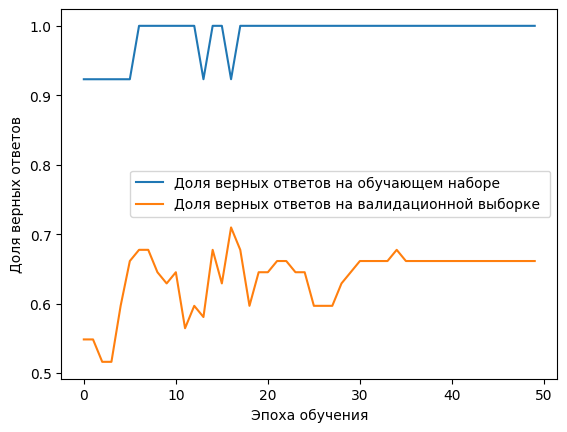

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label ='Доля верных ответов на валидационной выборке ')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

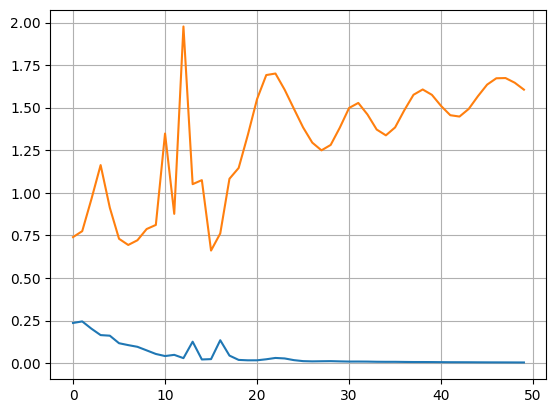

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.show()

In [ ]:
x_test = (['Распоряжение об утверждении проекта границ земельного участка выдается заявителю не позднее семи календарных дней с момента его обращения'])

In [ ]:
x_test_neg = (['В случаях, требующих проведения специальной проверки, истребования дополнительных материалов, принятия других мер, срок рассмотрения обращения может быть продлен'])

In [ ]:
#model.get_weights()

In [ ]:
sequences = tokenizer.texts_to_sequences(x_test)

In [ ]:
sequences = tokenizer.texts_to_sequences(x_test_neg)

In [ ]:
x_test = pad_sequences(sequences,maxlen=max_sent_len )

In [ ]:
x_test_neg = pad_sequences(sequences,maxlen=max_sent_len )

In [ ]:
x_test

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  39,  86,  17,
        118,  40, 119, 120,  71,  33, 121,  41,  14,   5,   6,   8,  15,
         87]], dtype=int32)

In [ ]:
x_train [2]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  90,  25,  91,  92,
        93,  27,  30,  59,  26,   9,  34, 169,  60,  12,  11,  35,  61,
         6], dtype=int32)

In [ ]:
tokenizer.word_index['вправе']

202

In [ ]:
model.predict(x_test)

1/1 [==============================] - 0s 486ms/step


array([[0.9993766]], dtype=float32)

In [ ]:
model.predict(x_test_neg)

1/1 [==============================] - 0s 42ms/step


array([[0.9993766]], dtype=float32)

In [ ]:
test_2 = ['Гражданину может быть отказано в постановке на учет в качестве нуждающегося в улучшении жилищных условий по следующим основаниям: не указывает четко на то должностное лицо, которое компетентно рассматривать его жалобу, это порождает возможность «запуска по кругу» заявителя при защите им своих нарушенных прав']

In [ ]:
sequences = tokenizer.texts_to_sequences(test_2)

In [ ]:
test_2 = pad_sequences(sequences,maxlen=max_sent_len )

In [ ]:
model.predict(test_2)

1/1 [==============================] - 0s 96ms/step


array([[0.5421035]], dtype=float32)

In [ ]:
test_3 = ['Уполномоченный орган вправе расторгнуть договор на свое усмотрение.']

In [ ]:
sequences = tokenizer.texts_to_sequences(test_3)

In [ ]:
test_3 = pad_sequences(sequences,maxlen=max_sent_len )

In [ ]:
model.predict(test_3)

1/1 [==============================] - 1s 659ms/step


array([[0.9487375]], dtype=float32)

In [ ]:
test_neg_4 = ['При необходимости, заявителю необходимо предоставить копию документа воинского учета']

In [ ]:
sequences = tokenizer.texts_to_sequences(test_neg_4)

In [ ]:
test_neg_4 = pad_sequences(sequences, maxlen=max_sent_len )

In [ ]:
model.predict(test_neg_4)

1/1 [==============================] - 0s 69ms/step


array([[0.93956774]], dtype=float32)

In [ ]:
test_pos_0 =['Уведомление о продлении срока рассмотрения обращения (промежуточный ответ) направляется заявителю заблаговременно (не позднее чем за 2 дня до истечения срока)']

In [ ]:
sequences = tokenizer.texts_to_sequences(test_pos_0)

In [ ]:
test_pos_0 = pad_sequences(sequences,maxlen=max_sent_len )

In [ ]:
result = model.predict(test_pos_0)
if result < 0.5:
  print ('НПА составлен корректно')
  if result >0.5:
    print('Есть риски')

1/1 [==============================] - 0s 44ms/step
НПА составлен корректно


In [ ]:
def result (text):

  sequences = tokenizer.texts_to_sequences(text)
  text = pad_sequences(sequences,maxlen=max_sent_len )
  result = model.predict(text)

  if result < 0.5:
    return 'Фрагмент НПА составлен корректно'
  else:
    return 'Фрагмент НПА несет в себе риски наличия коррупциогенных факторов'

In [ ]:
text = ['Уведомление о продлении срока рассмотрения обращения (промежуточный ответ) направляется заявителю заблаговременно (не позднее чем за 2 дня до истечения срока)']

In [ ]:
result(text)

1/1 [==============================] - 0s 44ms/step


'Фрагмент НПА составлен корректно'

In [ ]:
result(text)

1/1 [==============================] - 0s 84ms/step


'Фрагмент НПА составлен корректно'

In [ ]:
text_1 = (['Распоряжение об утверждении проекта границ земельного участка выдается заявителю не позднее семи календарных дней с момента его обращения'])

In [ ]:
result(text_1)

1/1 [==============================] - 0s 45ms/step


'Фрагмент НПА составлен корректно'

In [ ]:
text_2 = ['Уполномоченный орган вправе расторгнуть договор на свое усмотрение.']

In [ ]:
result(text_2)

1/1 [==============================] - 0s 52ms/step


'Фрагмент НПА несет в себе риски наличия коррупциогенных факторов'

In [ ]:
text_3 = ['Уведомление о продлении срока рассмотрения обращения (промежуточный ответ) направляется заявителю заблаговременно (не позднее чем за 2 дня до истечения срока)']

In [ ]:
result(text_3)

1/1 [==============================] - 0s 65ms/step


'Фрагмент НПА несет в себе риски наличия коррупциогенных факторов'

In [ ]:
text_4 = ['При необходимости, заявителю необходимо предоставить копию документа воинского учета']

In [ ]:
result(text_4)

1/1 [==============================] - 0s 75ms/step


'Фрагмент НПА несет в себе риски наличия коррупциогенных факторов'